In [375]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from scipy.interpolate import RBFInterpolator
from tqdm import tqdm
# import open3d as o3d
import os
from pyquaternion import Quaternion
# from floorplan_utils import *
# from img_utils import *

In [376]:
def ralign(X, Y):
    m, n = X.shape

    mx = X.mean(1)
    my = Y.mean(1)

    Xc = X - mx[..., None]
    Yc = Y - my[..., None]

    sx = Xc.var(1).sum()
    sy = Yc.var(1).sum()

    Sxy = np.dot(Yc, Xc.T) / n

    S = np.ones(m)
    if np.linalg.det(Sxy) < 0:
        S[m - 1] = -1

    U, D, V = np.linalg.svd(Sxy)

    r = np.linalg.matrix_rank(Sxy)

    if r >= (m - 1):
        if r == m - 1:
            if np.linalg.det(U) * np.linalg.det(V) > 0:
                R = np.dot(U, V)
            else:
                s_ = S[m - 1]
                S[m - 1] = -1
                R = np.dot(U, np.dot(np.diag(S), V))
                S[m - 1] = s_
        else:
            R = np.dot(U, np.dot(np.diag(S), V))
    else:
        return (None, None, None, None)

    DS = np.dot(D, S)

    c = DS / sx
    t = my - c * np.dot(R, mx)

    e = sy - DS**2 / sx

    return R, c, t, e

In [377]:
mpl.rcParams['figure.figsize'] = [15, 15]

In [378]:
# data_root = '/home/lipeize/catkin_liosam/saves/'
# seqs = ['2023-02-02-18-52-57-seq6-f0', 
#         '2023-02-02-19-03-11-seq7-f0', 
#         '2023-02-02-19-12-55-seq8-f0', 
#         '2023-02-02-19-24-52-seq9-f1', 
#         '2023-02-02-19-35-47-seq10-f1',
#         '2023-02-02-19-46-24-seq11-f1']
# seq_idx = 0
data_root = '../data/'
seqs = ['filter_3','filter_6','filter_7','filter_9']
seq_idx = 3

Read LAST line of path file.

In [379]:
# with open(os.path.join(data_root, seqs[seq_idx], 'path.csv'), 'r') as f:
#     lines = f.read().splitlines()
#     last_line = lines[-1]
# path = last_line.split(',')
# path = np.load(data_root+seqs[seq_idx]+ '.npy')
# path = np.array(path[4:]).reshape([-1, 10])
# path = np.delete(path, 2, 1)
# path = path.astype(float)
# gt_path = path[:, 2:5]

# df = pd.read_csv(data_root+seqs[seq_idx]+ '.csv')
df = pd.read_pickle("opt_df.pic")
# df = df.sort_values(by=['secs','nsecs'])
path = df[['x', 'y','z']].values
path = np.array(path)
path = path.astype(float)
# path.shape
df

,wf,gnss_lat,gnss_lon,z,z_raw,is_baro,t,x,y,pdr_vel,...,traj_id,gnss_easting,gnss_northing,theta,is_elevation,floor_id,elevation_height,max_dist,lat,lon
step_id,,,,,,,,,,,,,,,,,,,,,
1,"{'207394925875571': -47, '207394925875570': -4...",NaN,NaN,-0.003880,0.000000,True,5455892.0,19.429567,25.583819,0.69723,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942983,-3.188700
2,None,55.942823,-3.18914,-0.003880,0.000000,True,5455992.0,19.415120,25.540276,0.74234,...,0,-8.031963,7.682255,0,False,0.0,0.0,42.583348,55.942983,-3.188700
3,None,NaN,NaN,-0.003880,0.000000,True,5456252.0,19.310557,25.395203,0.84942,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942982,-3.188702
4,None,NaN,NaN,-0.003880,0.000000,True,5456482.0,19.195583,25.262586,0.93122,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942980,-3.188704
5,None,NaN,NaN,-0.003880,0.000000,True,5456692.0,19.073481,25.141082,0.99524,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942979,-3.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106334,"{'207394925917588': -83, '207394925917587': -8...",NaN,NaN,-0.011057,0.522397,True,11123112.0,16.343454,-5.394785,0.27198,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942705,-3.188749
106335,None,NaN,NaN,-0.011057,0.547007,True,11123832.0,16.132462,-5.426694,0.27993,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942705,-3.188753
106336,None,NaN,NaN,-0.011057,0.553463,True,11124532.0,15.920868,-5.465603,0.30507,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942704,-3.188756


In [380]:
seq_duration = (path[-1, 1] - path[0, 1]) / 1e9
print(seq_duration)

-3.1129635661051956e-08


(-16.205523589525512, 24.9163070405997, -35.99978714276452, 32.83104383596562)

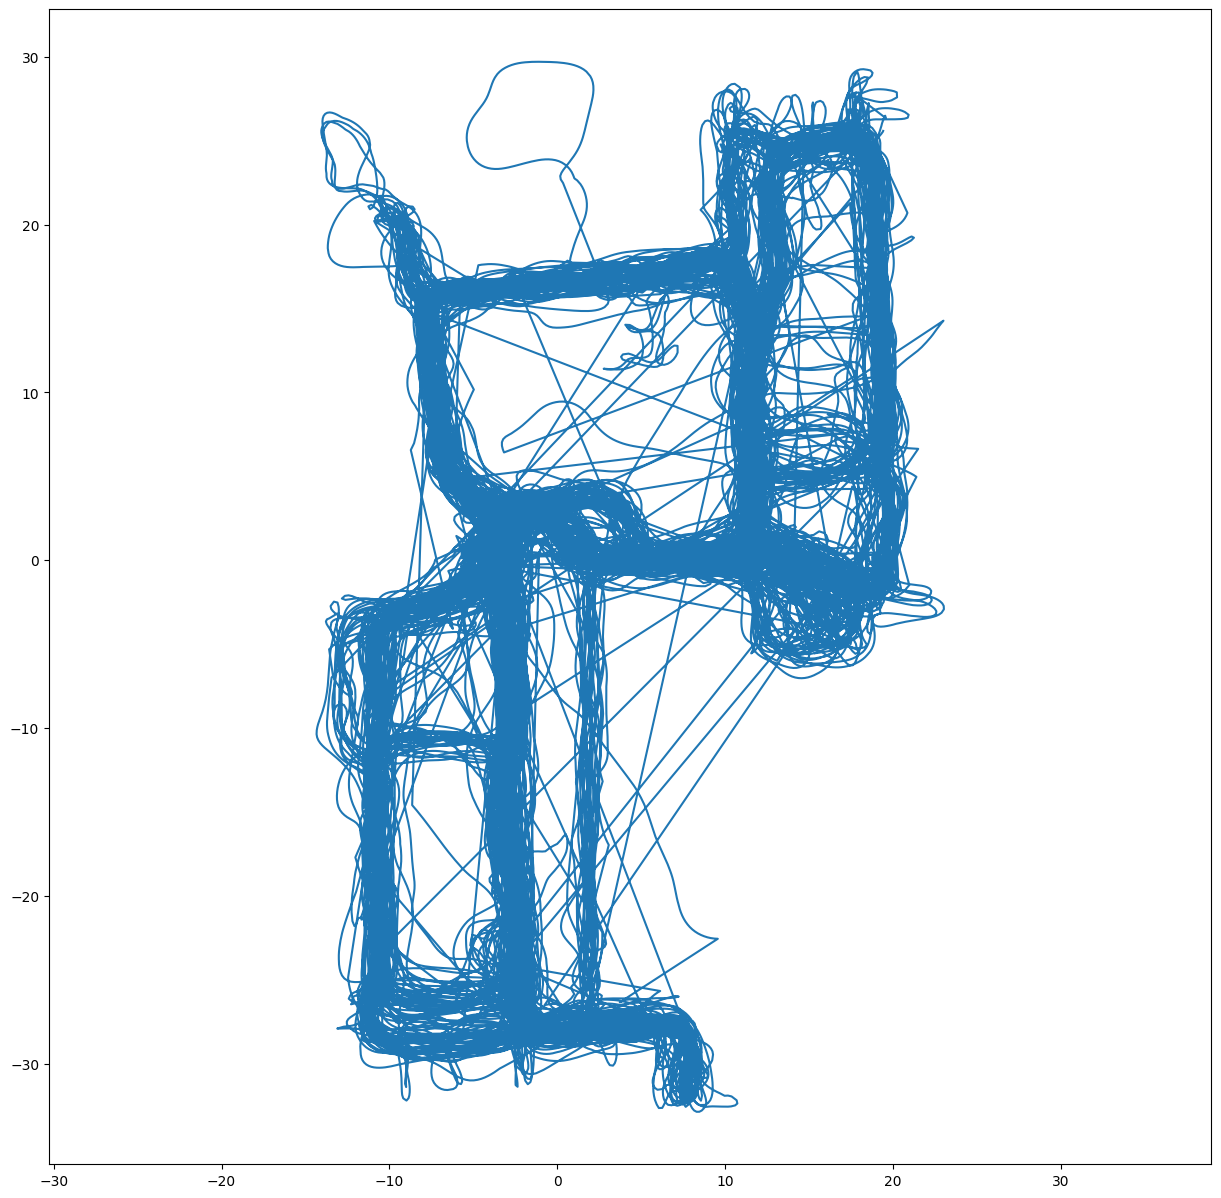

In [381]:
plt.plot(path[:, 0], path[:, 1])
plt.axis('equal')

In [394]:
# corners_gt = np.array([[5.944540, 39.708279, -0.520508],
#  [25.561304, 9.863537, -0.466914],
#  [-3.859824, -6.034390, 0.085863],
# [12.924220, -30.910660, 0.450827]])

# corners_gt = np.array([[-14.550963, 11.512155, -0.848353], 
#                        [11.399657, 30.526108, -0.594791], 
#                        [14.986525, 7.845741, -1.207359], 
#                        [3.370856, -4.656131, -1.457701]])

# x = corners_gt[:,0]
# y = corners_gt[:,1]
# plt.scatter(x, y)

# corners_gt = np.array([[2.959888, 46.526699, 0.384468],
# [39.828835, -7.806488, -1.175075],
# [15.363974, -38.455940, 1.737134],
# [-8.250896, -8.302032, 2.217922]])


# corners_gt = np.array([[2.959888, 46.526699, 0.384468],
#  [39.828835, -7.806488, -1.175075],
#  [15.363974, -38.455940, 1.737134],
# [-8.250896, -8.302032, 2.217922]])

corners_gt = np.array([[7.825, 32.316, 0],
[1.805, 26.934, 0],
 [1.7,26.3, 0],
[11.38,28.46, 0]])

# Point index picked: 86976 (real: 86976) - [6.472130, 39.414200, 0.478048]
# Point index picked: 64020 (real: 64020) - [33.364693, 14.977477, 0.279529]
# Point index picked: 15466 (real: 15466) - [15.117744, -38.073227, 3.057659]
# Point index picked: 37695 (real: 37695) - [-8.708307, -8.988010, 0.862633]

In [395]:
# corners_map = np.array([[523, -431, 0], 
#                         [1427, -365, 0], 
#                         [1165, -960, 0], 
#                         [693, -1088, 0]])

corners_map = np.array([[7000, 2598, 0], 
                        [6593, 3260, 0], 
                        [6667, 2853, 0], 
                        [7142, 4412, 0],
                        ])

# corners_map = np.array([
# [194,532, 0], 
# [1170,260, 0], 
# [2137,1187, 0], 
# [1282,1428, 0]])
# corners_map[:,0] = corners_map[:,0] - 9362/2 
# corners_map[:,1] = 6623/2 - corners_map[:,1]
corners_map[:,1] = corners_map[:,1]*-1
# corners_map = corners_map/80
# corners_map = corners_map /72/39.37 * 100
print(np.linalg.norm(corners_map[0] - corners_map[1]))
print(np.linalg.norm(corners_map[1] - corners_map[2]))
print(np.linalg.norm(corners_map[2] - corners_map[3]))
print(np.linalg.norm(corners_map[3] - corners_map[0]))
print("/scale")
corners_map = corners_map /200/39.37 * 100
print(np.linalg.norm(corners_map[0] - corners_map[1]))
print(np.linalg.norm(corners_map[1] - corners_map[2]))
print(np.linalg.norm(corners_map[2] - corners_map[3]))
print(np.linalg.norm(corners_map[3] - corners_map[0]))

777.1055269395528
413.67257583746107
1629.7564235185575
1819.5493947678365
/scale
9.869259930652175
5.2536522204401965
20.697947974581623
23.10832353019858


In [396]:
print(np.linalg.norm(corners_gt[0] - corners_gt[1]))
print(np.linalg.norm(corners_gt[1] - corners_gt[2]))
print(np.linalg.norm(corners_gt[2] - corners_gt[3]))
print(np.linalg.norm(corners_gt[3] - corners_gt[0]))

8.075043281617754
0.6426359778288175
9.91806432727677
5.244688837290542


In [385]:
# print(np.linalg.norm(corners_map[0] - corners_map[1]))
# print(np.linalg.norm(corners_map[1] - corners_map[2]))
# print(np.linalg.norm(corners_map[2] - corners_map[3]))
# print(np.linalg.norm(corners_map[3] - corners_map[0]))
# print("/scale")
# corners_map = corners_map /200/39.37 * 100
# print(np.linalg.norm(corners_map[0] - corners_map[1]))
# print(np.linalg.norm(corners_map[1] - corners_map[2]))
# print(np.linalg.norm(corners_map[2] - corners_map[3]))
# print(np.linalg.norm(corners_map[3] - corners_map[0]))

# x = 9362/200/39.37 * 100
# y = 6623/200/39.37 * 100

# x

In [386]:
alignment = ralign(corners_gt.T, corners_map.T)
print(alignment)

(array([[-0.2163777 ,  0.97630973,  0.        ],
       [ 0.97630973,  0.2163777 ,  0.        ],
       [ 0.        ,  0.        , -1.        ]]), 1.3461519702660063, array([ 49.33137739, -52.63872247,   0.        ]), 1.2788771177142628)


In [387]:
q = Quaternion(matrix=alignment[0])

In [388]:
gt_matched = []
# for i in gt_path:
for i in path:
    gt_matched.append(q.rotate(i) + alignment[2])
    # print(i)
gt_matched = np.array(gt_matched)

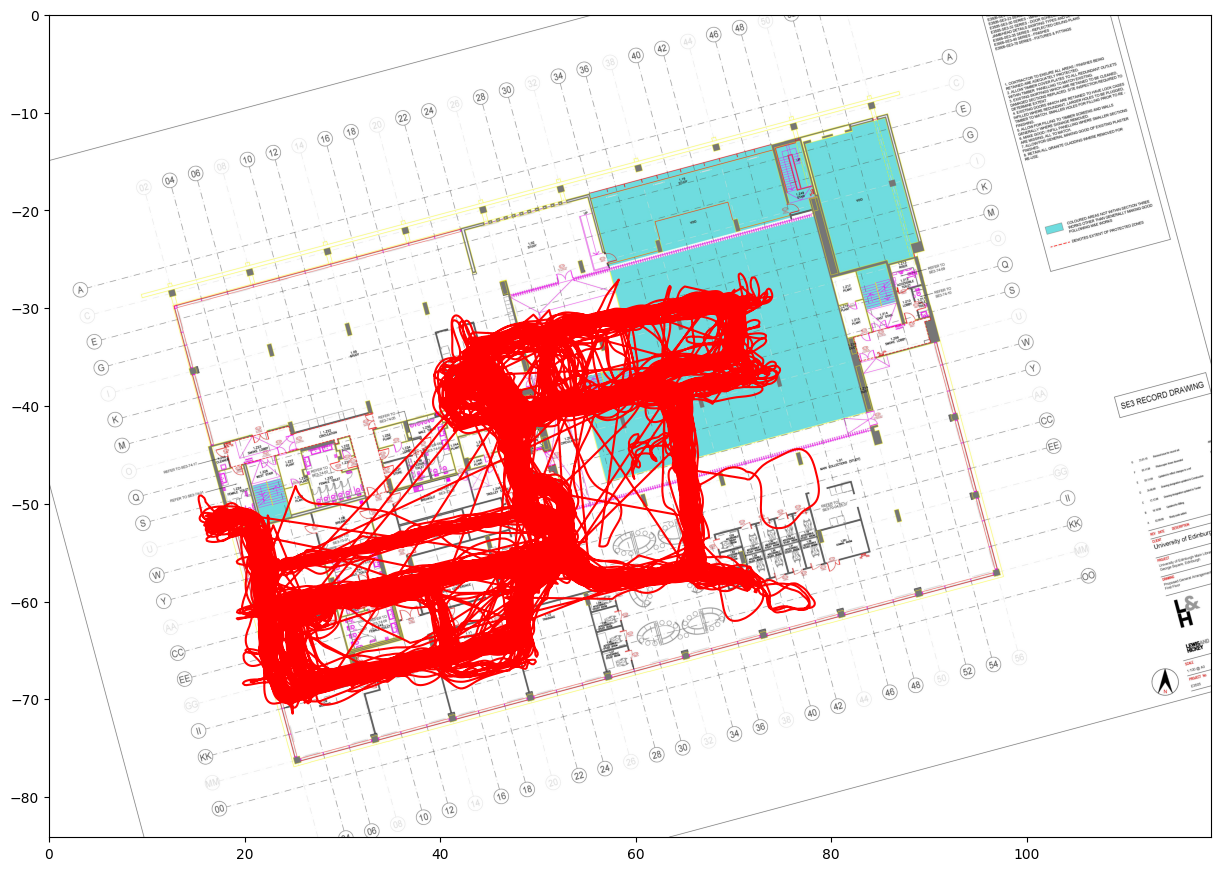

In [389]:
maxx= 9362/200/39.37 * 100
maxy= -6623/200/39.37 * 100
fig, ax = plt.subplots()
im = plt.imread("./2.png")
im = ax.imshow(im, extent=[0, maxx, maxy, 0])
ax.plot(gt_matched[:, 0], gt_matched[:, 1], c='r')

# df['x_calibrated'] = gt_matched[:, 0]
# df['y_calibrated'] = gt_matched[:, 1]
# df.to_csv("rotate_9.csv")

In [390]:
ts = path[:,1] / 1e7 - 1.675346097874434204e11
out = np.hstack((ts.reshape((-1, 1)), gt_matched[:,0:2]))
np.save(os.path.join(data_root, seqs[seq_idx], 'gt.npy'), out)

FileNotFoundError: [Errno 2] No such file or directory: '../data/filter_9\\gt.npy'

In [ ]:
from scipy import interpolate
fx = interpolate.interp1d(out[:,0], out[:,1])
fy = interpolate.interp1d(out[:,0], out[:,2])
ts_new = np.arange(out[0,0], out[-1,0], 10)
out_interpolate = np.hstack((ts_new.reshape((-1, 1)), fx(ts_new).reshape((-1, 1)), fy(ts_new).reshape((-1, 1))))
np.save(os.path.join(data_root, seqs[seq_idx], 'gt_interpolate.npy'), out_interpolate)

FileNotFoundError: [Errno 2] No such file or directory: '../data/filter_9\\gt_interpolate.npy'

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workdir/huawei_ips/F0_corrected_72.png'

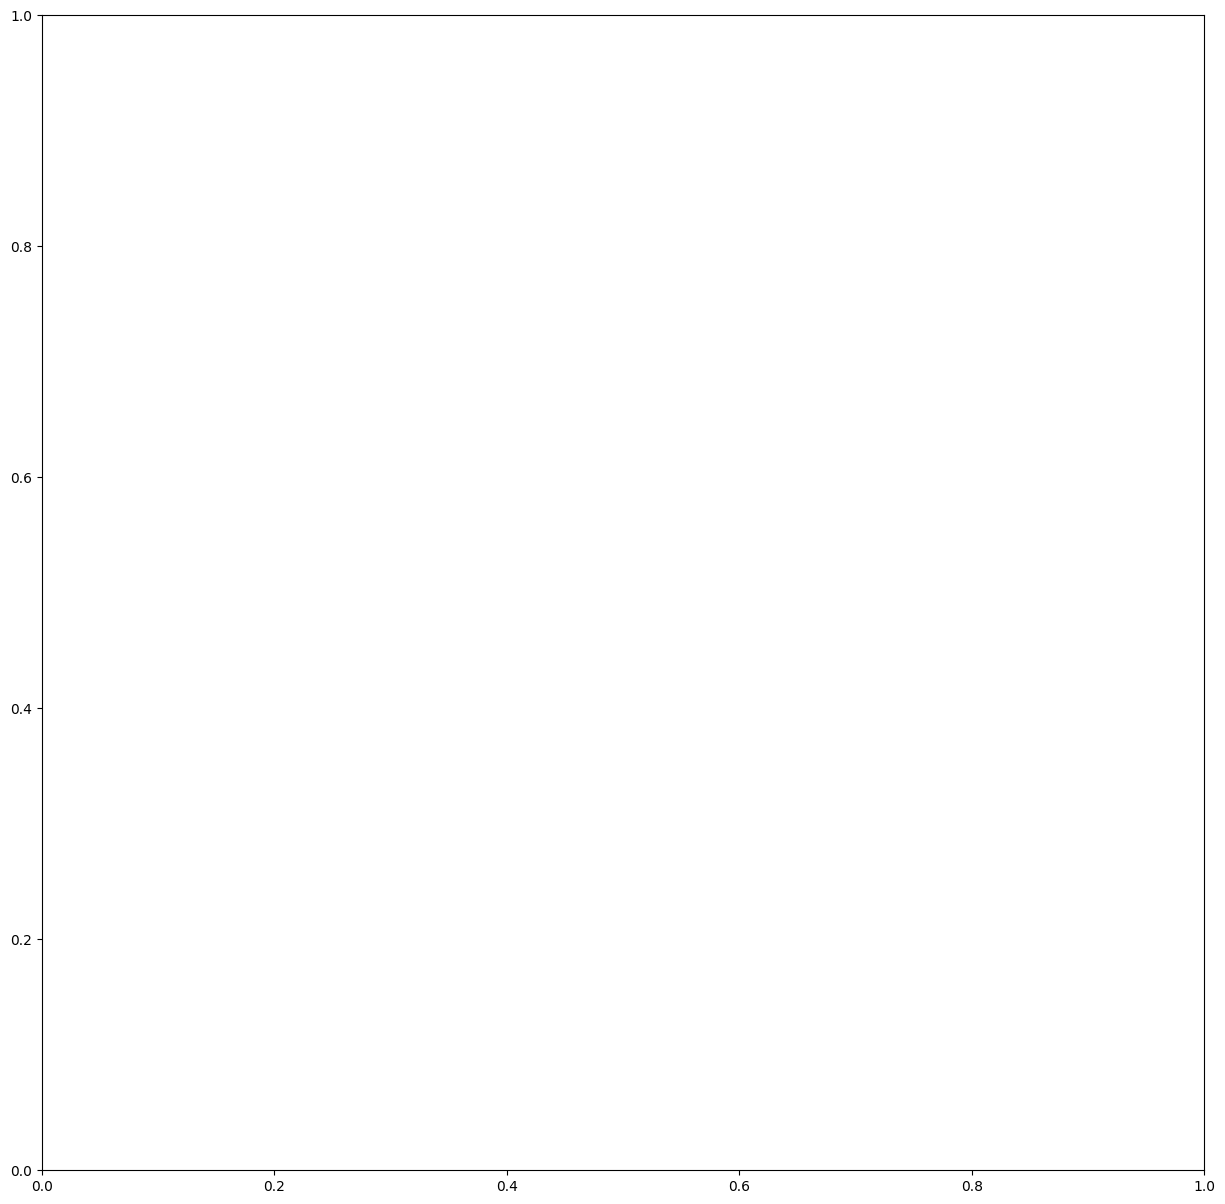

In [ ]:
fig, ax = plt.subplots()
im = plt.imread("/mnt/workdir/huawei_ips/F0_corrected_72.png")
im = ax.imshow(im, extent=[0, maxx, maxy, 0])
ax.plot(out_interpolate[:, 1], out_interpolate[:, 2], c='r')

In [ ]:
out